In [4]:
pip install fastai

In [46]:
# Import required libraries
from fastai.vision.all import *
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import random

In [6]:
# Download and extract Imagenette
path = untar_data(URLs.IMAGENETTE)
print(f"Dataset path: {path}")

# Check the structure
print((path/'train').ls())
print((path/'val').ls())


Dataset path: /root/.fastai/data/imagenette2
[Path('/root/.fastai/data/imagenette2/train/n03888257'), Path('/root/.fastai/data/imagenette2/train/n03425413'), Path('/root/.fastai/data/imagenette2/train/n03417042'), Path('/root/.fastai/data/imagenette2/train/n02102040'), Path('/root/.fastai/data/imagenette2/train/n01440764'), Path('/root/.fastai/data/imagenette2/train/n03445777'), Path('/root/.fastai/data/imagenette2/train/n02979186'), Path('/root/.fastai/data/imagenette2/train/n03000684'), Path('/root/.fastai/data/imagenette2/train/n03028079'), Path('/root/.fastai/data/imagenette2/train/n03394916')]
[Path('/root/.fastai/data/imagenette2/val/n03888257'), Path('/root/.fastai/data/imagenette2/val/n03425413'), Path('/root/.fastai/data/imagenette2/val/n03417042'), Path('/root/.fastai/data/imagenette2/val/n02102040'), Path('/root/.fastai/data/imagenette2/val/n01440764'), Path('/root/.fastai/data/imagenette2/val/n03445777'), Path('/root/.fastai/data/imagenette2/val/n02979186'), Path('/root/.fa

In [10]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),
    get_y=parent_label,
    item_tfms=Resize(224)
)

# Create DataLoaders
dls = dblock.dataloaders(path, bs=64)


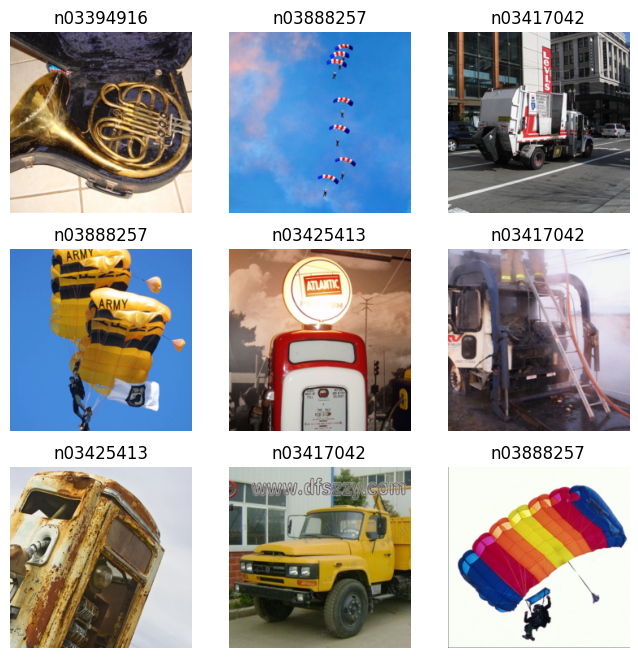

In [11]:
# Display sample images
dls.show_batch(max_n=9, figsize=(8, 8))

In [12]:
# Load GoogleNet Model and Modify for Imagenette
googlenet = models.googlenet(pretrained=True)
googlenet.fc = nn.Linear(googlenet.fc.in_features, dls.c)

learn = Learner(dls, googlenet, metrics=accuracy)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 77.1MB/s]


In [13]:
history = {'epoch': [], 'train_loss': [], 'valid_loss': [], 'accuracy': []}

for epoch in range(10):
    learn.fit(1)  # Train for 1 epoch
    metrics = learn.recorder.values[-1]  # Get the latest validation metrics
    train_loss, valid_loss, acc = metrics[0], metrics[1], metrics[2]
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['accuracy'].append(acc)
    print(f"Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Valid Loss={valid_loss:.4f}, Accuracy={acc:.4f}")


epoch,train_loss,valid_loss,accuracy,time
0,0.336741,0.418973,0.865223,01:35


Epoch 1: Train Loss=0.3367, Valid Loss=0.4190, Accuracy=0.8652


epoch,train_loss,valid_loss,accuracy,time
0,0.260396,0.332518,0.892994,01:34


Epoch 2: Train Loss=0.2604, Valid Loss=0.3325, Accuracy=0.8930


epoch,train_loss,valid_loss,accuracy,time
0,0.217855,0.328163,0.898853,01:33


Epoch 3: Train Loss=0.2179, Valid Loss=0.3282, Accuracy=0.8989


epoch,train_loss,valid_loss,accuracy,time
0,0.198987,0.296093,0.910064,01:33


Epoch 4: Train Loss=0.1990, Valid Loss=0.2961, Accuracy=0.9101


epoch,train_loss,valid_loss,accuracy,time
0,0.164401,0.403880,0.881019,01:35


Epoch 5: Train Loss=0.1644, Valid Loss=0.4039, Accuracy=0.8810


epoch,train_loss,valid_loss,accuracy,time
0,0.166170,0.675562,0.821911,01:34


Epoch 6: Train Loss=0.1662, Valid Loss=0.6756, Accuracy=0.8219


epoch,train_loss,valid_loss,accuracy,time
0,0.126020,0.287777,0.913121,01:33


Epoch 7: Train Loss=0.1260, Valid Loss=0.2878, Accuracy=0.9131


epoch,train_loss,valid_loss,accuracy,time
0,0.102849,0.547444,0.867006,01:34


Epoch 8: Train Loss=0.1028, Valid Loss=0.5474, Accuracy=0.8670


epoch,train_loss,valid_loss,accuracy,time
0,0.117519,0.295510,0.914395,01:36


Epoch 9: Train Loss=0.1175, Valid Loss=0.2955, Accuracy=0.9144


epoch,train_loss,valid_loss,accuracy,time
0,0.094460,0.456741,0.878981,01:35


Epoch 10: Train Loss=0.0945, Valid Loss=0.4567, Accuracy=0.8790


In [14]:
# Final Accuracy and Loss
final_acc = history['accuracy'][-1]
final_loss = history['valid_loss'][-1]
print(f"\nFinal Validation Accuracy: {final_acc * 100:.2f}%")
print(f"Final Validation Loss: {final_loss:.4f}")



Final Validation Accuracy: 87.90%
Final Validation Loss: 0.4567


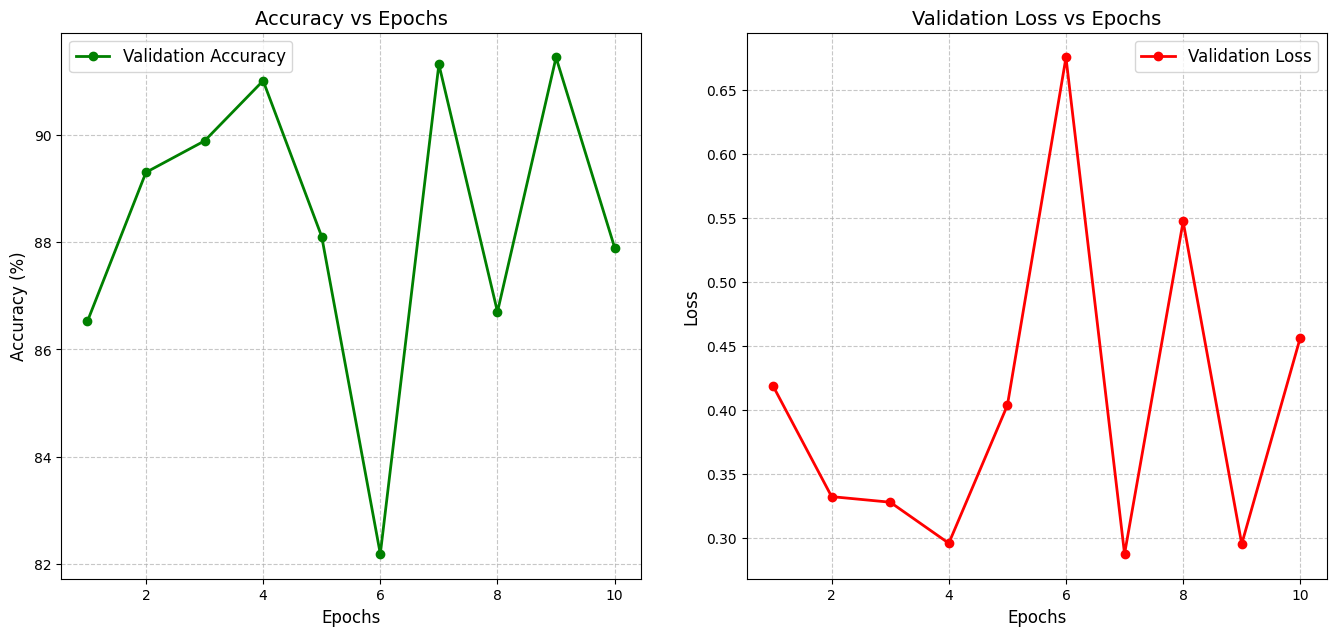

In [18]:
# Plot Accuracy and Loss vs. Epochs
epochs = history['epoch']

plt.figure(figsize=(14, 7))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, [acc * 100 for acc in history['accuracy']], marker='o', linestyle='-', color='green', linewidth=2, markersize=6, label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy vs Epochs', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history['valid_loss'], marker='o', linestyle='-', color='red', linewidth=2, markersize=6, label='Validation Loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Validation Loss vs Epochs', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

plt.tight_layout(pad=3.0)
plt.show()


In [21]:
# Get predictions and true labels
preds, targets = learn.get_preds()
pred_labels = preds.argmax(dim=1)


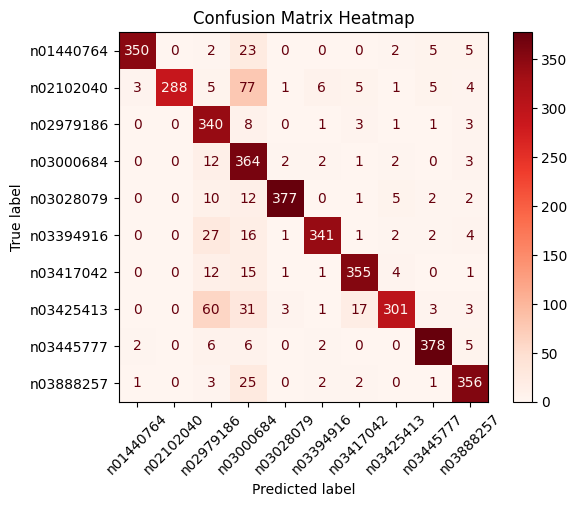

In [25]:
# Plot Confusion Matrix
cm = confusion_matrix(targets, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab)
disp.plot(cmap='Reds', xticks_rotation=45)
plt.title('Confusion Matrix Heatmap')
plt.show()

In [26]:
# Classification Report
report = classification_report(targets, pred_labels, target_names=dls.vocab, digits=4)
print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

   n01440764     0.9831    0.9044    0.9421       387
   n02102040     1.0000    0.7291    0.8433       395
   n02979186     0.7128    0.9524    0.8153       357
   n03000684     0.6308    0.9430    0.7560       386
   n03028079     0.9792    0.9218    0.9496       409
   n03394916     0.9579    0.8655    0.9093       394
   n03417042     0.9221    0.9126    0.9173       389
   n03425413     0.9465    0.7184    0.8168       419
   n03445777     0.9521    0.9474    0.9497       399
   n03888257     0.9223    0.9128    0.9175       390

    accuracy                         0.8790      3925
   macro avg     0.9007    0.8807    0.8817      3925
weighted avg     0.9035    0.8790    0.8823      3925



In [27]:
# calculate Precision, Recall, and F1-Score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(targets, pred_labels, average='macro')
recall = recall_score(targets, pred_labels, average='macro')
f1 = f1_score(targets, pred_labels, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 0.9007
Recall: 0.8807
F1-Score: 0.8817


Accuracy on 10 random images: 90.00%


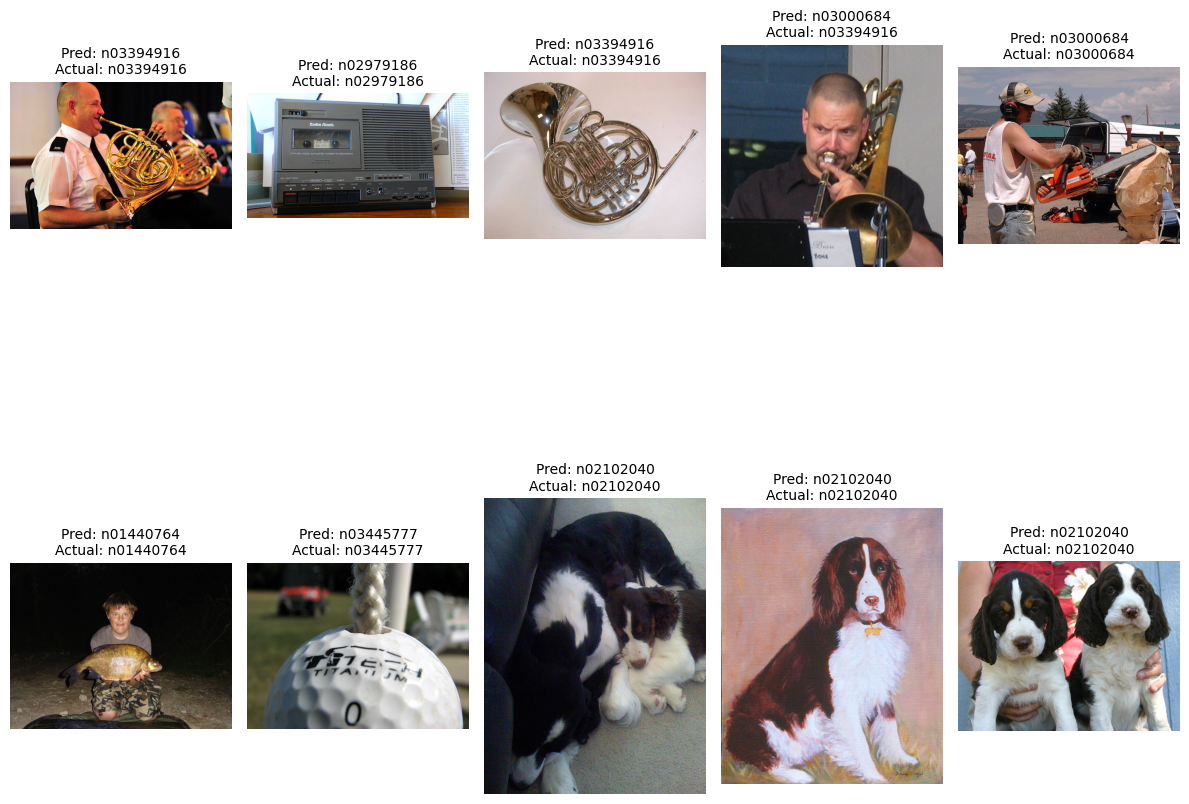

In [44]:
# Calculate accuracy by classifying any 10 images from the dataset

valid_dl = dls.valid
sample_indices = random.sample(range(len(valid_dl.dataset)), 10)

images = []
labels = []
for idx in sample_indices:
    img, lbl = valid_dl.dataset[idx]
    images.append(img)
    labels.append(lbl)

model_preds = []
for img in images:
    pred, _, _ = learn.predict(img)
    model_preds.append(pred)

correct = sum([pred == dls.vocab[actual_idx] for pred, actual_idx in zip(model_preds, labels)])
accuracy = correct / len(labels)

print(f"Accuracy on 10 random images: {accuracy * 100:.2f}%")

# Display the images with their predicted and actual labels
plt.figure(figsize=(12, 12))
for i, img in enumerate(images):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {model_preds[i]}\nActual: {dls.vocab[labels[i]]}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()
